# Manual tinkering, viewing loss traces of various models, trying to narrow in on a ballpark after skorch results

In [9]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib

import altair as alt
import seaborn as sns
import torch_utils as tu

import torch




# ReTrain some

In [2]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping,Checkpoint
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [3]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

log_data_filename = "data/XY_logTPM_opFilt.tsv"
XY = pd.read_csv(log_data_filename,sep='\t')

display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249


{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


In [4]:
for df in [XY]:
    df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
    df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])

In [5]:
def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

(1763, 18)
(441, 18)
(1410, 19)
(353, 19)


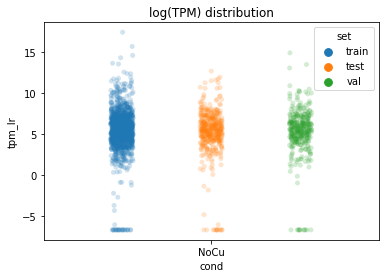

In [6]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


coi = "NoCu"
assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
view_train_test_dist(train_df, test_df,[coi],"log(TPM)",val_df=val_df)

In [7]:
def make_st_skorch_dfs(df,seq_col='seq',target_col='score'):
    '''
    Make basic X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    # had to unsqueeze here or else errors later
    
    return ohe_seqs.float(), labels.float()

In [10]:
Xtrain, ytrain = make_st_skorch_dfs(train_df, seq_col="upstream_region",target_col=coi)
print("Xtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_st_skorch_dfs(val_df, seq_col="upstream_region",target_col=coi)
print("Xval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_st_skorch_dfs(test_df, seq_col="upstream_region",target_col=coi)
print("Xtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_st_skorch_dfs(full_train_df, seq_col="upstream_region",target_col=coi)
print("Xfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)

Xtrain: torch.Size([1410, 300, 4])
ytrain: torch.Size([1410, 1])
Xval: torch.Size([353, 300, 4])
yval: torch.Size([353, 1])
Xtest: torch.Size([441, 300, 4])
ytest: torch.Size([441, 1])
Xfull_train: torch.Size([1763, 300, 4])
yfull_train: torch.Size([1763, 1])


In [11]:
# make skorch predefined valid ds
valid_ds = Dataset(Xval, yval)

## pick some params

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [14]:
# just pick some
# Adam, 32 filt, fast LR
net_regr1 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=128,
    module__kernel_size1=16,
    module__kernel_size2=8,
    module__conv_pool_size1=6, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.0,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr2 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=64,
    module__num_filters2=32,
    module__kernel_size1=8,
    module__kernel_size2=32,
    module__conv_pool_size1=6, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=3000,
    lr=0.0001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

In [15]:
net_regr1.fit(Xtrain, ytrain)
net_regr2.fit(Xtrain, ytrain)

final linear_node_num: 5120
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       15.7936       10.4303     +  1.3236
      2        8.5771        9.6369     +  0.0613
      3        7.1644        8.5642     +  0.0610
      4        7.2014        8.8864        0.0610
      5        7.0794        8.5501     +  0.0602
      6        6.9098        8.5397     +  0.0548
      7        6.8297        8.5477        0.0560
      8        6.9231        8.9318        0.0545
      9        6.8794        8.6854        0.0534
     10        7.2953        8.6306        0.0535
     11        7.8243        9.5444        0.0532
     12        7.0698        8.4904     +  0.0522
     13        6.8754        8.6982        0.0534
     14        6.7792        8.5868        0.0515
     15        6.7275        8.5314        0.0517
     16        6.6659        8.6589        0.0516
     17        6.7097        8.4246     +  0.0513
     18        6.5291 

    146        1.5786        7.2567     +  0.0533
    147        1.3552        7.3236        0.0547
    148        1.4187        7.4149        0.0535
    149        1.5315        7.3458        0.0534
    150        1.3965        7.4200        0.0533
    151        1.3249        7.3506        0.0533
    152        1.3132        7.2568        0.0531
    153        1.3187        7.1613     +  0.0531
    154        1.3516        7.1722        0.0534
    155        1.2445        7.1958        0.0531
    156        1.2681        7.2462        0.0533
    157        1.2411        7.3221        0.0532
    158        1.2678        7.1926        0.0508
    159        1.2998        7.2297        0.0459
    160        1.1498        7.1580     +  0.0455
    161        1.2043        7.1582        0.0463
    162        1.1967        7.1505     +  0.0533
    163        1.2024        7.3203        0.0533
    164        1.1931        7.4078        0.0531
    165        1.3618        7.2117        0.0531


    302        0.9410        6.6079        0.0468
    303        0.7752        6.7057        0.0469
    304        0.9010        6.6200        0.0464
    305        0.6477        6.6541        0.0535
    306        0.7400        6.5984        0.0553
    307        0.7164        6.6354        0.0610
    308        0.6593        6.6424        0.0588
    309        0.6894        6.7534        0.0575
    310        0.6644        6.7050        0.0619
    311        0.6660        6.6590        0.0602
    312        0.6519        6.6421        0.0599
    313        0.6661        6.6524        0.0597
    314        0.6482        6.7450        0.0621
    315        0.6079        6.6978        0.0576
    316        0.6467        6.7015        0.0572
    317        0.6010        6.6961        0.0630
    318        0.6079        6.7088        0.0583
    319        0.6895        6.7029        0.0557
    320        0.6688        6.7406        0.0564
    321        0.6719        6.8032        0.0578


    463        0.5384        6.5274        0.0532
    464        0.4882        6.6372        0.0531
    465        0.4731        6.6120        0.0531
    466        0.4740        6.5566        0.0531
    467        0.5260        6.5529        0.0532
    468        0.4827        6.5897        0.0530
    469        0.5203        6.6518        0.0530
    470        0.5400        6.5628        0.0529
    471        0.5022        6.5498        0.0452
    472        0.4989        6.5275        0.0461
    473        0.4858        6.5698        0.0461
    474        0.4731        6.5189        0.0461
    475        0.4333        6.6149        0.0502
    476        0.4914        6.7209        0.0520
    477        0.4946        6.6845        0.0518
    478        0.5085        6.5486        0.0518
    479        0.5310        6.5362        0.0517
    480        0.5147        6.5303        0.0518
    481        0.4938        6.4994        0.0523
    482        0.5035        6.4965        0.0523


    625        0.3960        6.3677        0.0471
    626        0.3965        6.3816        0.0469
    627        0.3765        6.3829        0.0467
    628        0.3966        6.4085        0.0510
    629        0.4472        6.5258        0.0522
    630        0.4048        6.3756        0.0520
    631        0.3716        6.4756        0.0525
    632        0.4238        6.4776        0.0526
    633        0.4028        6.4748        0.0523
    634        0.3584        6.4390        0.0521
    635        0.3865        6.5506        0.0521
    636        0.4423        6.5610        0.0520
    637        0.4579        6.4914        0.0520
    638        0.4100        6.4522        0.0523
    639        0.4064        6.3155        0.0524
    640        0.4263        6.3716        0.0522
    641        0.3947        6.3173        0.0523
    642        0.4181        6.3003        0.0524
    643        0.3860        6.4113        0.0524
    644        0.4355        6.4660        0.0526


    788        0.3434        6.3430        0.0533
    789        0.3551        6.5015        0.0533
    790        0.4059        6.5118        0.0534
    791        0.3851        6.3111        0.0531
    792        0.3388        6.2280        0.0531
    793        0.4541        6.2745        0.0474
    794        0.4336        6.3017        0.0533
    795        0.4287        6.2622        0.0532
    796        0.3508        6.2905        0.0531
    797        0.3907        6.2924        0.0533
    798        0.3206        6.3014        0.0532
    799        0.3908        6.2887        0.0522
    800        0.3805        6.3247        0.0515
    801        0.3527        6.3148        0.0516
    802        0.3557        6.2851        0.0517
    803        0.3403        6.3361        0.0517
    804        0.3571        6.3339        0.0516
    805        0.3357        6.4680        0.0519
    806        0.4005        6.3828        0.0517
    807        0.3434        6.3078        0.0508


    950        0.2921        6.1120        0.0520
    951        0.3044        6.2441        0.0519
    952        0.3564        6.2821        0.0514
    953        0.3491        6.1639        0.0517
    954        0.3142        6.1378        0.0516
    955        0.3127        6.2000        0.0516
    956        0.3382        6.1664        0.0518
    957        0.3242        6.1663        0.0516
    958        0.3258        6.2049        0.0516
    959        0.3094        6.2164        0.0514
    960        0.3128        6.2253        0.0516
    961        0.3126        6.2005        0.0515
    962        0.2897        6.1656        0.0519
    963        0.3145        6.1542        0.0516
    964        0.3287        6.1769        0.0518
    965        0.3183        6.1944        0.0518
    966        0.2994        6.2388        0.0517
    967        0.2923        6.2732        0.0525
    968        0.3146        6.3308        0.0522
    969        0.2979        6.3030        0.0524


   1112        0.2861        5.9842     +  0.0458
   1113        0.2836        5.9901        0.0467
   1114        0.2698        5.9907        0.0463
   1115        0.2792        5.9934        0.0462
   1116        0.2671        5.9869        0.0462
   1117        0.2747        5.9514     +  0.0463
   1118        0.3153        5.9645        0.0475
   1119        0.3000        5.9985        0.0465
   1120        0.3316        6.0592        0.0464
   1121        0.3388        6.1420        0.0463
   1122        0.3188        6.1118        0.0463
   1123        0.3703        6.1032        0.0462
   1124        0.3674        6.1164        0.0462
   1125        0.3575        6.1040        0.0461
   1126        0.3846        6.0485        0.0460
   1127        0.3424        6.0714        0.0464
   1128        0.2857        6.1061        0.0532
   1129        0.3165        6.0999        0.0534
   1130        0.2906        6.0664        0.0535
   1131        0.4332        6.1673        0.0533


   1275        0.2815        5.9846        0.0541
   1276        0.2637        5.9387        0.0538
   1277        0.3006        5.9779        0.0538
   1278        0.2785        5.9939        0.0538
   1279        0.2852        6.0207        0.0537
   1280        0.2897        6.0606        0.0542
   1281        0.2748        6.0307        0.0539
   1282        0.2700        5.9862        0.0554
   1283        0.2846        5.9697        0.0547
   1284        0.2802        5.9863        0.0538
   1285        0.2643        6.0284        0.0537
   1286        0.2710        5.9649        0.0536
   1287        0.2854        5.9750        0.0535
   1288        0.2863        5.9790        0.0536
   1289        0.3079        6.0241        0.0534
   1290        0.2838        6.1808        0.0535
   1291        0.3411        6.0175        0.0534
   1292        0.3027        5.9518        0.0533
   1293        0.2916        5.9519        0.0536
   1294        0.3330        5.9466        0.0534


   1438        0.2678        6.0165        0.0541
   1439        0.2818        6.0066        0.0542
   1440        0.2646        6.0001        0.0543
   1441        0.2521        5.9827        0.0544
   1442        0.2363        6.0680        0.0553
   1443        0.2537        5.9999        0.0551
   1444        0.2550        6.0211        0.0538
   1445        0.2722        5.9838        0.0461
   1446        0.2632        6.0145        0.0460
   1447        0.2571        6.0134        0.0459
   1448        0.2594        5.9668        0.0458
   1449        0.2500        5.9535        0.0458
   1450        0.2634        5.9851        0.0459
   1451        0.2459        5.9757        0.0458
   1452        0.2506        5.9660        0.0460
   1453        0.2464        5.9727        0.0461
   1454        0.2521        5.9659        0.0457
   1455        0.2620        5.9657        0.0456
   1456        0.3132        6.0131        0.0455
   1457        0.2918        6.0214        0.0455


   1602        0.2481        6.0443        0.0462
   1603        0.2843        6.0344        0.0466
   1604        0.2646        6.0431        0.0466
   1605        0.2340        6.0371        0.0463
   1606        0.2487        6.0353        0.0464
   1607        0.2418        6.0327        0.0462
   1608        0.2870        6.1192        0.0463
   1609        0.3087        6.1015        0.0463
   1610        0.3135        6.0796        0.0464
   1611        0.2801        6.0789        0.0463
   1612        0.2534        6.0809        0.0461
   1613        0.2510        6.0596        0.0462
   1614        0.2341        6.0358        0.0460
   1615        0.2570        6.0211        0.0462
   1616        0.2564        6.0583        0.0465
   1617        0.2448        6.0967        0.0462
   1618        0.2518        6.1191        0.0462
   1619        0.2368        6.1103        0.0463
   1620        0.2425        6.0812        0.0462
   1621        0.2480        6.0720        0.0462


   1766        0.2627        5.9706        0.0537
   1767        0.2566        5.9692        0.0536
   1768        0.2568        5.9336        0.0537
   1769        0.2291        5.9277        0.0535
   1770        0.2331        5.9304        0.0535
   1771        0.2540        6.0411        0.0535
   1772        0.3152        5.9654        0.0534
   1773        0.2764        5.9173        0.0536
   1774        0.2456        5.8819        0.0529
   1775        0.2409        5.9180        0.0457
   1776        0.2399        5.9156        0.0464
   1777        0.2405        5.9228        0.0457
   1778        0.2247        5.9203        0.0459
   1779        0.2300        5.9243        0.0459
   1780        0.2286        5.9342        0.0529
   1781        0.2789        5.9571        0.0526
   1782        0.2631        5.9637        0.0543
   1783        0.2319        5.9775        0.0539
   1784        0.2326        5.9378        0.0539
   1785        0.2605        5.9330        0.0537


   1930        0.2430        5.9295        0.0464
   1931        0.2450        5.9641        0.0465
   1932        0.2282        5.9695        0.0463
   1933        0.2212        5.9310        0.0536
   1934        0.2256        5.9143        0.0470
   1935        0.2292        5.9050        0.0467
   1936        0.2430        5.9073        0.0540
   1937        0.2123        5.9086        0.0541
   1938        0.2197        5.9040        0.0534
   1939        0.2485        5.9058        0.0534
   1940        0.2287        5.9077        0.0535
   1941        0.2180        5.9113        0.0534
   1942        0.2422        5.9311        0.0535
   1943        0.2245        5.9415        0.0536
   1944        0.2311        5.9246        0.0534
   1945        0.2409        5.9713        0.0534
   1946        0.2207        5.9375        0.0536
   1947        0.2720        5.8921        0.0539
   1948        0.2534        5.9103        0.0538
   1949        0.2536        5.9440        0.0539


   2094        0.2332        5.9503        0.0468
   2095        0.2533        5.8911        0.0466
   2096        0.2304        5.9002        0.0464
   2097        0.2346        5.9803        0.0466
   2098        0.3136        5.9740        0.0467
   2099        0.2620        5.9389        0.0466
   2100        0.2407        5.9258        0.0466
   2101        0.2318        5.9240        0.0514
   2102        0.2679        5.9210        0.0465
   2103        0.2368        5.9295        0.0471
   2104        0.2264        5.9178        0.0469
   2105        0.2310        5.9229        0.0466
   2106        0.2144        5.9447        0.0465
   2107        0.2293        5.9365        0.0465
   2108        0.2651        5.9941        0.0465
   2109        0.2563        5.9679        0.0466
   2110        0.2409        5.9588        0.0465
   2111        0.2431        5.9557        0.0463
   2112        0.2296        5.9252        0.0465
   2113        0.2461        5.9633        0.0459


   2258        0.2303        5.9498        0.0460
   2259        0.2153        5.9333        0.0459
   2260        0.2243        5.8974        0.0458
   2261        0.2259        5.9072        0.0458
   2262        0.2168        5.9200        0.0460
   2263        0.2285        5.9287        0.0464
   2264        0.2127        5.9213        0.0459
   2265        0.2063        5.8970        0.0460
   2266        0.2048        5.8976        0.0461
   2267        0.2156        5.9252        0.0458
   2268        0.2209        5.9481        0.0460
   2269        0.2442        5.9909        0.0457
   2270        0.2480        5.9585        0.0458
   2271        0.2083        5.9528        0.0459
   2272        0.2352        5.9296        0.0459
   2273        0.2069        5.9516        0.0460
   2274        0.2173        5.9613        0.0461
   2275        0.2319        5.9620        0.0463
   2276        0.2071        5.9346        0.0464
   2277        0.2102        5.9345        0.0466


   2422        0.2165        5.8724        0.0471
   2423        0.1974        5.8869        0.0473
   2424        0.2028        5.9217        0.0471
   2425        0.2020        5.9263        0.0474
   2426        0.2030        5.9088        0.0475
   2427        0.2081        5.9180        0.0474
   2428        0.2057        5.9422        0.0474
   2429        0.2419        5.9405        0.0472
   2430        0.2136        5.9343        0.0473
   2431        0.2060        5.9272        0.0473
   2432        0.2070        5.9370        0.0473
   2433        0.2302        5.9909        0.0471
   2434        0.2397        5.9565        0.0475
   2435        0.2211        5.9204        0.0475
   2436        0.2187        5.9127        0.0474
   2437        0.2131        5.9219        0.0474
   2438        0.1996        5.9227        0.0476
   2439        0.2039        5.9126        0.0474
   2440        0.2108        5.9004        0.0473
   2441        0.2025        5.9354        0.0472


   2586        0.2296        5.8828        0.0473
   2587        0.2020        5.9030        0.0477
   2588        0.2377        5.9727        0.0475
   2589        0.2262        6.0116        0.0478
   2590        0.2500        5.9820        0.0477
   2591        0.2385        5.9256        0.0475
   2592        0.2266        5.9258        0.0474
   2593        0.2042        5.9258        0.0475
   2594        0.2134        5.9328        0.0480
   2595        0.2286        5.9601        0.0478
   2596        0.2139        5.9414        0.0479
   2597        0.2049        5.9514        0.0476
   2598        0.2353        5.9510        0.0477
   2599        0.2326        5.9560        0.0478
   2600        0.2183        5.9509        0.0476
   2601        0.2168        5.9301        0.0471
   2602        0.2059        5.9106        0.0475
   2603        0.2288        5.9016        0.0470
   2604        0.2419        5.8979        0.0472
   2605        0.2088        5.9000        0.0469


     73        6.6128        8.4334     +  0.0546
     74        6.6350        8.4663        0.0546
     75        6.6493        8.4531        0.0546
     76        6.6248        8.4622        0.0544
     77        6.6721        8.4736        0.0544
     78        6.6585        8.4432        0.0547
     79        6.6831        8.4934        0.0548
     80        6.6759        8.4165     +  0.0553
     81        6.6668        8.4687        0.0550
     82        6.6423        8.4173        0.0547
     83        6.7270        8.4572        0.0574
     84        6.7723        8.4150     +  0.0563
     85        7.3387        8.4020     +  0.0564
     86        6.7769        8.5774        0.0563
     87        6.6502        8.4120        0.0561
     88        6.5948        8.5284        0.0560
     89        6.5745        8.4518        0.0562
     90        6.6709        8.4390        0.0559
     91        6.6172        8.3849     +  0.0562
     92        6.5796        8.5031        0.0566


    225        5.3996        7.9443     +  0.0489
    226        5.4045        8.0782        0.0491
    227        5.3043        7.9983        0.0489
    228        5.3565        7.9306     +  0.0488
    229        5.3796        8.1915        0.0493
    230        5.3431        7.9482        0.0494
    231        5.3554        8.1992        0.0493
    232        5.3158        7.9237     +  0.0494
    233        5.2226        7.9626        0.0494
    234        5.2022        7.9225     +  0.0491
    235        5.1797        7.9732        0.0492
    236        5.2281        7.9123     +  0.0491
    237        5.1673        7.8966     +  0.0490
    238        5.6298        8.1997        0.0494
    239        5.3258        7.9959        0.0492
    240        5.4392        8.2589        0.0502
    241        5.1852        7.8697     +  0.0561
    242        5.1251        8.0530        0.0561
    243        5.2287        7.9587        0.0566
    244        5.2580        7.8714        0.0566


    379        4.0953        7.7987        0.0514
    380        3.8130        8.2272        0.0567
    381        3.8798        7.5978        0.0564
    382        3.6757        7.6411        0.0566
    383        3.6390        7.5181     +  0.0563
    384        3.5552        7.6179        0.0567
    385        3.5546        7.5441        0.0564
    386        3.4957        7.5833        0.0562
    387        3.5146        7.5963        0.0564
    388        3.6052        7.4938     +  0.0567
    389        3.4684        7.5915        0.0577
    390        3.5738        7.8205        0.0567
    391        3.6096        7.5149        0.0562
    392        3.4586        7.7069        0.0561
    393        3.4090        7.6483        0.0561
    394        3.2754        7.4314     +  0.0562
    395        3.6033        7.8116        0.0499
    396        3.4607        7.4690        0.0498
    397        3.3344        7.5624        0.0495
    398        3.4663        7.5337        0.0494


    537        2.5761        7.2099        0.0567
    538        2.4643        7.2801        0.0563
    539        2.5266        7.4675        0.0564
    540        2.6306        7.2760        0.0563
    541        2.5686        7.4536        0.0565
    542        2.5171        7.2777        0.0565
    543        2.4895        7.1441        0.0564
    544        2.5195        7.5275        0.0564
    545        2.6095        7.2401        0.0562
    546        2.4162        7.2090        0.0562
    547        2.5656        7.4223        0.0567
    548        2.5445        7.1499        0.0566
    549        2.4618        7.1907        0.0563
    550        2.7838        7.8411        0.0562
    551        2.5725        7.3921        0.0543
    552        2.5334        7.2331        0.0543
    553        2.6091        7.6239        0.0546
    554        2.4810        7.2535        0.0550
    555        2.6091        7.4544        0.0553
    556        2.5112        7.2196        0.0495


    697        1.8443        7.1986        0.0549
    698        1.8322        6.9703        0.0498
    699        2.2208        7.1057        0.0500
    700        1.8368        7.2224        0.0496
    701        2.0267        6.9615        0.0496
    702        1.9901        6.8231     +  0.0496
    703        1.9838        6.9293        0.0508
    704        1.8123        7.2200        0.0499
    705        1.8399        7.0077        0.0494
    706        1.7591        7.0375        0.0492
    707        1.7368        7.0259        0.0545
    708        1.8569        7.1372        0.0545
    709        1.7566        6.9135        0.0546
    710        1.7965        6.9156        0.0544
    711        1.9239        7.0927        0.0544
    712        1.7418        7.0193        0.0543
    713        1.8432        7.0634        0.0544
    714        1.9290        6.8780        0.0551
    715        1.7733        6.9519        0.0492
    716        2.0008        7.1077        0.0492


    858        1.3960        6.9698        0.0556
    859        1.4755        6.9969        0.0557
    860        1.5117        6.8370        0.0555
    861        1.3876        6.9585        0.0552
    862        1.3823        6.8163        0.0551
    863        1.4447        6.9657        0.0551
    864        1.3465        6.9733        0.0552
    865        1.5597        6.9654        0.0551
    866        1.6090        7.2587        0.0551
    867        1.4853        6.8107        0.0551
    868        1.3678        6.8145        0.0552
    869        1.3804        6.8146        0.0550
    870        1.4295        6.8022        0.0555
    871        1.3728        6.9224        0.0554
    872        1.3226        6.6778     +  0.0553
    873        1.4739        6.7018        0.0551
    874        1.3264        6.8865        0.0547
    875        1.3644        6.8345        0.0547
    876        1.3958        6.8938        0.0548
    877        1.3497        6.7403        0.0548


   1020        1.2230        6.6633        0.0501
   1021        1.0915        6.8214        0.0501
   1022        1.1011        6.6805        0.0502
   1023        1.1439        6.6868        0.0502
   1024        1.0960        6.7170        0.0503
   1025        1.0620        6.6154        0.0502
   1026        1.1632        6.9089        0.0503
   1027        1.2472        6.7308        0.0502
   1028        1.1321        6.7790        0.0500
   1029        1.1628        6.7716        0.0501
   1030        1.0917        6.7053        0.0502
   1031        1.0664        6.6296        0.0505
   1032        1.1152        6.6856        0.0507
   1033        1.0833        6.6680        0.0536
   1034        1.1020        6.6573        0.0555
   1035        1.1351        6.7769        0.0555
   1036        1.0716        6.7106        0.0552
   1037        1.1579        6.6508        0.0552
   1038        1.1504        6.6672        0.0551
   1039        1.0807        6.7680        0.0550


   1183        1.0066        6.9442        0.0566
   1184        0.9772        6.6484        0.0566
   1185        0.9339        6.5949        0.0565
   1186        1.0137        6.6147        0.0495
   1187        0.9190        6.6969        0.0499
   1188        1.1345        6.8199        0.0566
   1189        0.8933        6.7688        0.0495
   1190        1.0396        6.7657        0.0495
   1191        1.0524        6.7206        0.0494
   1192        0.9032        6.6740        0.0498
   1193        0.9455        6.7414        0.0496
   1194        0.8925        6.7517        0.0496
   1195        0.8997        6.7683        0.0498
   1196        0.9377        6.6644        0.0503
   1197        1.0366        6.7563        0.0566
   1198        0.9594        6.6454        0.0564
   1199        0.9850        6.6714        0.0565
   1200        0.8949        6.6942        0.0564
   1201        0.8957        6.7769        0.0565
   1202        1.0150        6.6073        0.0565


   1345        0.7432        6.6428        0.0502
   1346        0.8676        6.6040        0.0500
   1347        0.7713        6.6165        0.0502
   1348        0.8137        6.6580        0.0503
   1349        0.8211        6.5942        0.0502
   1350        0.7908        6.6070        0.0501
   1351        0.8064        6.6438        0.0507
   1352        0.8124        6.6575        0.0509
   1353        0.8107        6.6316        0.0503
   1354        0.8043        6.7735        0.0503
   1355        0.9333        6.7025        0.0503
   1356        0.8021        6.5974        0.0502
   1357        0.8484        6.5966        0.0502
   1358        0.8492        6.5751        0.0503
   1359        0.8267        6.6432        0.0502
   1360        0.8150        6.7302        0.0502
   1361        0.7698        6.5983        0.0502
   1362        0.8373        6.5266        0.0503
   1363        0.8139        6.5287        0.0501
   1364        0.8253        6.5967        0.0502


   1508        0.6924        6.5981        0.0550
   1509        0.6888        6.6267        0.0551
   1510        0.7770        6.5443        0.0550
   1511        0.7560        6.4799        0.0549
   1512        0.7192        6.5268        0.0550
   1513        0.7385        6.5390        0.0550
   1514        0.6958        6.5413        0.0552
   1515        0.7145        6.5811        0.0555
   1516        0.7531        6.6729        0.0551
   1517        0.7286        6.5158        0.0552
   1518        0.7231        6.5099        0.0551
   1519        0.7479        6.5634        0.0552
   1520        0.7293        6.5525        0.0554
   1521        0.7058        6.5103        0.0557
   1522        0.7718        6.5404        0.0557
   1523        0.7731        6.5544        0.0561
   1524        0.6773        6.5466        0.0572
   1525        0.7422        6.5512        0.0565
   1526        0.6773        6.5316        0.0561
   1527        0.7000        6.5309        0.0557


   1670        0.6102        6.4946        0.0566
   1671        0.6920        6.4589        0.0564
   1672        0.6312        6.4434        0.0565
   1673        0.6817        6.4458        0.0566
   1674        0.6481        6.4730        0.0566
   1675        0.5954        6.4887        0.0566
   1676        0.6523        6.4942        0.0565
   1677        0.6385        6.4590        0.0568
   1678        0.6359        6.4992        0.0567
   1679        0.6378        6.4766        0.0568
   1680        0.6487        6.4409        0.0568
   1681        0.6166        6.4381        0.0567
   1682        0.6603        6.4209        0.0568
   1683        0.6157        6.6236        0.0571
   1684        0.8329        6.7209        0.0565
   1685        0.6561        6.5719        0.0502
   1686        0.6802        6.4389        0.0567
   1687        0.6342        6.4824        0.0565
   1688        0.6377        6.3825     +  0.0566
   1689        0.6846        6.4688        0.0509


   1833        0.5715        6.3327        0.0585
   1834        0.6108        6.3924        0.0584
   1835        0.5617        6.4135        0.0579
   1836        0.6106        6.3450        0.0577
   1837        0.5704        6.3839        0.0577
   1838        0.5936        6.3484        0.0579
   1839        0.6267        6.3745        0.0577
   1840        0.5932        6.3634        0.0575
   1841        0.5628        6.4039        0.0568
   1842        0.5903        6.4001        0.0514
   1843        0.5725        6.4377        0.0506
   1844        0.5876        6.3596        0.0568
   1845        0.5633        6.3385        0.0496
   1846        0.5790        6.3487        0.0552
   1847        0.5842        6.4030        0.0501
   1848        0.6160        6.3202     +  0.0503
   1849        0.5790        6.3460        0.0567
   1850        0.6247        6.3865        0.0567
   1851        0.5599        6.4369        0.0503
   1852        0.6261        6.4308        0.0501


   1997        0.5043        6.3226        0.0497
   1998        0.5163        6.3374        0.0497
   1999        0.5205        6.3767        0.0497
   2000        0.5120        6.3432        0.0497
   2001        0.5298        6.3753        0.0497
   2002        0.5590        6.3680        0.0499
   2003        0.5274        6.3849        0.0500
   2004        0.5780        6.3714        0.0499
   2005        0.5190        6.3928        0.0502
   2006        0.4940        6.4034        0.0501
   2007        0.5564        6.3599        0.0499
   2008        0.5325        6.3220        0.0498
   2009        0.5357        6.3474        0.0499
   2010        0.5211        6.3686        0.0501
   2011        0.5502        6.3749        0.0501
   2012        0.5417        6.3160        0.0500
   2013        0.5125        6.3322        0.0499
   2014        0.5683        6.3501        0.0502
   2015        0.5631        6.4584        0.0506
   2016        0.5741        6.3279        0.0502


   2160        0.4886        6.3122        0.0496
   2161        0.4924        6.3477        0.0497
   2162        0.4941        6.3162        0.0498
   2163        0.4787        6.2748        0.0498
   2164        0.4964        6.3282        0.0500
   2165        0.5052        6.3797        0.0502
   2166        0.5264        6.3914        0.0501
   2167        0.4440        6.3678        0.0500
   2168        0.4655        6.3686        0.0498
   2169        0.4574        6.3540        0.0498
   2170        0.4673        6.3684        0.0498
   2171        0.4893        6.3721        0.0498
   2172        0.5127        6.3390        0.0496
   2173        0.4945        6.3184        0.0496
   2174        0.5031        6.4063        0.0496
   2175        0.5137        6.3972        0.0496
   2176        0.5372        6.3892        0.0496
   2177        0.5019        6.3478        0.0497
   2178        0.4737        6.3801        0.0499
   2179        0.5403        6.3404        0.0504


   2324        0.4494        6.2967        0.0500
   2325        0.4306        6.3054        0.0498
   2326        0.4493        6.2713        0.0496
   2327        0.5029        6.2903        0.0500
   2328        0.4671        6.3162        0.0501
   2329        0.4604        6.3616        0.0503
   2330        0.4755        6.3250        0.0506
   2331        0.4797        6.2824        0.0509
   2332        0.5156        6.2971        0.0505
   2333        0.4804        6.3160        0.0505
   2334        0.4624        6.3382        0.0509
   2335        0.4560        6.3501        0.0508
   2336        0.4495        6.3517        0.0505
   2337        0.4636        6.2892        0.0503
   2338        0.4543        6.2642        0.0502
   2339        0.4931        6.2547        0.0559
   2340        0.4732        6.2745        0.0558
   2341        0.4770        6.3539        0.0554
   2342        0.4734        6.3398        0.0555
   2343        0.5025        6.4785        0.0557


   2487        0.4495        6.2548        0.0561
   2488        0.4532        6.2840        0.0558
   2489        0.4343        6.3828        0.0559
   2490        0.4402        6.3097        0.0564
   2491        0.4503        6.3012        0.0562
   2492        0.4432        6.2807        0.0561
   2493        0.4170        6.2143        0.0558
   2494        0.4764        6.2470        0.0557
   2495        0.4306        6.2531        0.0556
   2496        0.4505        6.2734        0.0521
   2497        0.4381        6.2685        0.0510
   2498        0.4274        6.3094        0.0508
   2499        0.4433        6.3059        0.0507
   2500        0.4495        6.2416        0.0519
   2501        0.4397        6.2272        0.0508
   2502        0.4155        6.2505        0.0508
   2503        0.4546        6.2613        0.0510
   2504        0.4066        6.1990     +  0.0508
   2505        0.4768        6.1362     +  0.0520
   2506        0.4318        6.2180        0.0524


   2651        0.4271        6.1922        0.0507
   2652        0.4210        6.3027        0.0511
   2653        0.4190        6.2546        0.0509
   2654        0.4342        6.2124        0.0511
   2655        0.4483        6.2088        0.0509
   2656        0.4435        6.1913        0.0510
   2657        0.4039        6.2110        0.0509
   2658        0.4386        6.2173        0.0515
   2659        0.4002        6.2263        0.0514
   2660        0.4202        6.2152        0.0512
   2661        0.4589        6.2698        0.0515
   2662        0.4655        6.2980        0.0514
   2663        0.3982        6.2687        0.0511
   2664        0.4407        6.2544        0.0509
   2665        0.4437        6.2283        0.0511
   2666        0.4016        6.2694        0.0518
   2667        0.4673        6.2548        0.0515
   2668        0.4542        6.2237        0.0511
   2669        0.4147        6.2619        0.0509
   2670        0.4631        6.2774        0.0508


   2815        0.3979        6.2146        0.0561
   2816        0.4177        6.2019        0.0560
   2817        0.4047        6.2015        0.0561
   2818        0.4009        6.1892        0.0562
   2819        0.4097        6.2289        0.0562
   2820        0.4202        6.1945        0.0559
   2821        0.4582        6.2468        0.0560
   2822        0.4463        6.2248        0.0557
   2823        0.3827        6.2204        0.0559
   2824        0.4105        6.2161        0.0558
   2825        0.4419        6.2145        0.0557
   2826        0.4535        6.1986        0.0557
   2827        0.4171        6.1932        0.0559
   2828        0.4361        6.1779        0.0559
   2829        0.4219        6.2037        0.0556
   2830        0.4530        6.1594        0.0557
   2831        0.4575        6.2111        0.0560
   2832        0.3983        6.1698        0.0557
   2833        0.3827        6.1736        0.0568
   2834        0.4377        6.2042        0.0562


   2978        0.3758        6.1079        0.0569
   2979        0.4315        6.1475        0.0566
   2980        0.4020        6.1200        0.0562
   2981        0.3476        6.1235        0.0564
   2982        0.3487        6.1278        0.0563
   2983        0.3820        6.1502        0.0561
   2984        0.4168        6.1396        0.0561
   2985        0.3525        6.1216        0.0569
   2986        0.3390        6.1450        0.0565
   2987        0.3973        6.1420        0.0561
   2988        0.4143        6.1981        0.0563
   2989        0.4563        6.1000        0.0561
   2990        0.3962        6.1322        0.0560
   2991        0.4260        6.1154        0.0561
   2992        0.3897        6.1385        0.0560
   2993        0.3486        6.1326        0.0563
   2994        0.3997        6.1771        0.0564
   2995        0.3813        6.1877        0.0561
   2996        0.4067        6.1571        0.0562
   2997        0.3932        6.1490        0.0542


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 6), stride=(1, 6), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=544, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

In [16]:
net_regr3 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=8,
    module__kernel_size2=32,
    module__conv_pool_size1=6, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.5,
    module__dropout2 = 0.2,
    max_epochs=3000,
    lr=0.0001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr3.fit(Xtrain,ytrain)

final linear_node_num: 544
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       34.6024       32.6661     +  0.0489
      2       31.0756       28.2564     +  0.0479
      3       25.7401       21.9666     +  0.0472
      4       18.5832       14.9228     +  0.0473
      5       11.5730        9.7470     +  0.0470
      6        7.5326        8.6341     +  0.0471
      7        7.1859        8.8964        0.0467
      8        7.1178        8.7091        0.0469
      9        7.0456        8.5955     +  0.0470
     10        7.0307        8.5805     +  0.0472
     11        7.0605        8.5947        0.0474
     12        7.0267        8.6992        0.0473
     13        7.0835        8.6569        0.0473
     14        7.0724        8.5727     +  0.0471
     15        7.0899        8.5713     +  0.0472
     16        7.0525        8.6472        0.0477
     17        7.0684        8.6571        0.0474
     18        7.0584  

    152        6.6236        8.4114        0.0472
    153        6.6630        8.5972        0.0472
    154        6.7474        8.4007        0.0471
    155        6.6498        8.3992        0.0469
    156        6.6179        8.4429        0.0469
    157        6.5600        8.4883        0.0477
    158        6.7652        8.6370        0.0483
    159        6.6666        8.3650     +  0.0477
    160        6.6650        8.4200        0.0475
    161        6.6022        8.4079        0.0475
    162        6.6397        8.3694        0.0473
    163        6.6746        8.4331        0.0473
    164        6.6246        8.4211        0.0471
    165        6.6329        8.4038        0.0471
    166        6.6457        8.4074        0.0472
    167        6.6186        8.3722        0.0472
    168        6.6224        8.4309        0.0470
    169        6.6331        8.3669        0.0472
    170        6.6061        8.3586     +  0.0470
    171        6.6333        8.3650        0.0473


    309        6.4515        8.2123        0.0537
    310        6.3796        8.2552        0.0536
    311        6.2550        8.1915     +  0.0536
    312        6.3535        8.1881     +  0.0556
    313        6.1892        8.3348        0.0540
    314        6.2762        8.2341        0.0536
    315        6.2083        8.3292        0.0535
    316        6.1963        8.2282        0.0535
    317        6.3247        8.2620        0.0533
    318        6.4073        8.2862        0.0532
    319        6.2716        8.1814     +  0.0474
    320        6.2903        8.3777        0.0475
    321        6.1758        8.1938        0.0474
    322        6.2905        8.2095        0.0475
    323        6.2717        8.2426        0.0474
    324        6.2144        8.2033        0.0470
    325        6.2253        8.2219        0.0475
    326        6.2491        8.1806     +  0.0477
    327        6.2038        8.2524        0.0484
    328        6.2651        8.2033        0.0474


    466        5.8661        8.0626        0.0487
    467        6.0168        8.1896        0.0485
    468        5.9333        7.9952     +  0.0482
    469        5.9443        8.0859        0.0480
    470        5.7930        8.0182        0.0480
    471        5.7944        8.0753        0.0480
    472        5.9765        8.0099        0.0480
    473        5.9817        7.9911     +  0.0482
    474        5.9168        8.0994        0.0482
    475        5.9483        8.1047        0.0481
    476        5.8744        7.9859     +  0.0478
    477        5.8551        8.0109        0.0481
    478        5.9649        8.2185        0.0479
    479        5.8929        7.9790     +  0.0481
    480        5.9567        8.0256        0.0493
    481        5.8654        7.9778     +  0.0479
    482        5.9307        7.9861        0.0487
    483        5.8397        7.9995        0.0478
    484        5.8490        8.0853        0.0479
    485        5.8058        7.9841        0.0476


    623        5.4305        7.8044        0.0535
    624        5.6602        7.8282        0.0538
    625        5.5423        7.8701        0.0535
    626        5.5934        7.8148        0.0536
    627        5.6465        7.7882     +  0.0535
    628        5.4975        7.8616        0.0552
    629        5.4518        7.8663        0.0541
    630        5.6282        7.7921        0.0538
    631        5.5246        7.8682        0.0544
    632        5.4229        7.8201        0.0537
    633        5.4953        7.7835     +  0.0537
    634        5.3809        7.8104        0.0538
    635        5.5439        7.8762        0.0536
    636        5.4693        7.7734     +  0.0537
    637        5.6597        7.7723     +  0.0541
    638        5.4959        7.8307        0.0539
    639        5.5897        7.7833        0.0535
    640        5.5526        7.8164        0.0534
    641        5.3982        7.7656     +  0.0535
    642        5.4408        7.8007        0.0542


    781        5.0907        7.6974        0.0472
    782        5.1423        7.6468        0.0471
    783        5.0832        7.6952        0.0469
    784        5.0682        7.6351        0.0468
    785        5.0793        7.6776        0.0469
    786        5.1317        7.6593        0.0467
    787        5.0846        7.6485        0.0469
    788        5.0957        7.6248        0.0470
    789        5.0972        7.6345        0.0470
    790        5.1019        7.6613        0.0471
    791        5.1277        7.6231        0.0471
    792        4.9731        7.6170     +  0.0469
    793        5.1204        7.6138     +  0.0471
    794        5.2217        7.6262        0.0470
    795        5.0179        7.6103     +  0.0470
    796        5.2280        7.6637        0.0471
    797        5.0913        7.6238        0.0470
    798        5.1993        7.7091        0.0470
    799        5.0463        7.6029     +  0.0466
    800        5.1722        7.6308        0.0472


    938        4.7890        7.4330        0.0551
    939        4.7885        7.4296     +  0.0552
    940        4.8137        7.5396        0.0553
    941        4.8212        7.5320        0.0545
    942        4.7593        7.4261     +  0.0544
    943        4.7115        7.4507        0.0552
    944        4.9267        7.4413        0.0555
    945        4.7752        7.6097        0.0547
    946        4.6979        7.4223     +  0.0545
    947        4.7962        7.4404        0.0556
    948        4.6663        7.4536        0.0547
    949        4.7358        7.4304        0.0546
    950        4.6778        7.4575        0.0544
    951        4.8033        7.4256        0.0543
    952        4.8662        7.4835        0.0541
    953        4.7394        7.4572        0.0540
    954        4.5899        7.4079     +  0.0542
    955        4.8532        7.4166        0.0549
    956        4.6487        7.4086        0.0542
    957        4.7613        7.4111        0.0543


   1094        4.3645        7.3812        0.0539
   1095        4.4037        7.2087        0.0542
   1096        4.3261        7.2015        0.0539
   1097        4.5102        7.1693     +  0.0540
   1098        4.2759        7.3095        0.0526
   1099        4.4256        7.1679     +  0.0512
   1100        4.3854        7.1744        0.0529
   1101        4.4039        7.1699        0.0530
   1102        4.2610        7.1590     +  0.0550
   1103        4.5544        7.1668        0.0553
   1104        4.3963        7.1544     +  0.0557
   1105        4.3354        7.4225        0.0569
   1106        4.3680        7.2345        0.0565
   1107        4.3828        7.1701        0.0566
   1108        4.6471        7.2114        0.0560
   1109        4.3067        7.2955        0.0547
   1110        4.4141        7.2607        0.0508
   1111        4.4814        7.1749        0.0508
   1112        4.4226        7.1478     +  0.0510
   1113        4.3816        7.1820        0.0499


   1252        3.8340        7.0059        0.0552
   1253        3.9461        6.9888        0.0556
   1254        3.8693        6.9943        0.0553
   1255        4.0841        6.9415     +  0.0554
   1256        3.9776        6.9795        0.0571
   1257        4.0244        7.0525        0.0559
   1258        3.8482        6.9892        0.0556
   1259        4.1137        6.9622        0.0554
   1260        3.8310        6.9967        0.0554
   1261        4.0979        6.9676        0.0554
   1262        4.0050        7.0530        0.0553
   1263        3.9997        7.0204        0.0552
   1264        4.0279        6.9468        0.0553
   1265        3.8923        6.9721        0.0553
   1266        4.0499        6.9901        0.0553
   1267        3.8113        6.9571        0.0553
   1268        3.8273        6.9299     +  0.0553
   1269        4.0314        6.9667        0.0556
   1270        3.8999        6.9121     +  0.0553
   1271        4.0801        6.9000     +  0.0563


   1412        3.7816        6.7890        0.0539
   1413        3.7267        6.7555        0.0537
   1414        3.5977        6.7507        0.0538
   1415        3.6714        6.8060        0.0537
   1416        3.6307        6.7861        0.0537
   1417        3.6176        6.7483     +  0.0541
   1418        3.6820        6.7473     +  0.0546
   1419        3.6651        6.7413     +  0.0546
   1420        3.4770        6.7866        0.0547
   1421        3.6442        6.8390        0.0542
   1422        3.7388        6.7960        0.0539
   1423        3.5089        6.7386     +  0.0537
   1424        3.5127        6.7189     +  0.0547
   1425        3.5459        6.7487        0.0541
   1426        3.5310        6.7227        0.0537
   1427        3.5546        6.7354        0.0536
   1428        3.6331        6.6875     +  0.0540
   1429        3.7868        6.6738     +  0.0541
   1430        3.5411        6.7547        0.0516
   1431        3.5244        6.7316        0.0513


   1572        3.4267        6.5708        0.0469
   1573        3.3322        6.5147        0.0470
   1574        3.3927        6.5668        0.0554
   1575        3.1510        6.5612        0.0554
   1576        3.4414        6.4964     +  0.0535
   1577        3.2911        6.4838     +  0.0545
   1578        3.4017        6.5172        0.0538
   1579        3.4891        6.5511        0.0533
   1580        3.4881        6.5855        0.0535
   1581        3.3234        6.4975        0.0537
   1582        3.3370        6.5620        0.0537
   1583        3.2394        6.4445     +  0.0535
   1584        3.5427        6.4399     +  0.0477
   1585        3.2632        6.6962        0.0544
   1586        3.2225        6.4546        0.0564
   1587        3.2967        6.4647        0.0499
   1588        3.4008        6.4995        0.0491
   1589        3.4222        6.5139        0.0490
   1590        3.3318        6.5322        0.0491
   1591        3.3890        6.5268        0.0486


   1733        3.1847        6.4210        0.0488
   1734        3.1677        6.3966        0.0479
   1735        3.1174        6.4289        0.0479
   1736        2.9799        6.3376        0.0482
   1737        3.1685        6.3332     +  0.0483
   1738        3.1214        6.3561        0.0568
   1739        3.1681        6.3945        0.0498
   1740        3.0925        6.3221     +  0.0561
   1741        3.1364        6.3154     +  0.0480
   1742        3.1325        6.4467        0.0554
   1743        2.9842        6.3194        0.0565
   1744        3.0978        6.3488        0.0556
   1745        3.2180        6.4661        0.0485
   1746        3.1068        6.4526        0.0561
   1747        3.1307        6.3089     +  0.0558
   1748        3.0987        6.3063     +  0.0489
   1749        3.1470        6.3483        0.0527
   1750        3.2512        6.5353        0.0520
   1751        3.2168        6.3203        0.0521
   1752        3.0179        6.3503        0.0561


   1894        2.9693        6.2118        0.0546
   1895        2.8661        6.2623        0.0546
   1896        2.9510        6.2975        0.0540
   1897        3.0049        6.2102        0.0542
   1898        2.8755        6.2068        0.0541
   1899        2.9007        6.2710        0.0541
   1900        2.8606        6.2041        0.0542
   1901        2.9079        6.2169        0.0542
   1902        2.8337        6.1992        0.0543
   1903        3.0526        6.2268        0.0550
   1904        2.8443        6.2397        0.0548
   1905        2.9786        6.2321        0.0548
   1906        2.9119        6.2384        0.0546
   1907        2.8955        6.3017        0.0546
   1908        2.9707        6.1939        0.0552
   1909        3.0527        6.2132        0.0545
   1910        2.9603        6.1835     +  0.0547
   1911        2.9319        6.2329        0.0501
   1912        2.9358        6.3838        0.0489
   1913        2.8144        6.3276        0.0486


   2055        2.7845        6.0959        0.0545
   2056        2.7373        6.0978        0.0546
   2057        2.9670        6.0603        0.0546
   2058        2.7313        6.1086        0.0547
   2059        2.7110        6.0570        0.0546
   2060        2.9058        6.0527        0.0543
   2061        2.9344        6.0639        0.0546
   2062        2.7059        6.0946        0.0547
   2063        2.7847        6.1316        0.0549
   2064        2.8486        6.0772        0.0548
   2065        2.7006        6.0592        0.0544
   2066        2.7979        6.0580        0.0543
   2067        3.0034        6.0422     +  0.0545
   2068        2.8155        6.0783        0.0560
   2069        2.7641        6.0822        0.0546
   2070        2.6734        6.0579        0.0550
   2071        2.6483        6.0657        0.0539
   2072        2.7669        6.0774        0.0564
   2073        2.6749        6.0766        0.0477
   2074        2.7027        6.1075        0.0485


   2218        2.5732        6.0132        0.0484
   2219        2.5961        6.0162        0.0483
   2220        2.6987        6.0116        0.0563
   2221        2.7904        6.0081     +  0.0484
   2222        2.5963        6.0045     +  0.0498
   2223        2.5940        6.0057        0.0511
   2224        2.6428        6.0124        0.0542
   2225        2.6724        6.0009     +  0.0545
   2226        2.6165        6.0154        0.0564
   2227        2.6833        6.0293        0.0557
   2228        2.6282        6.0474        0.0543
   2229        2.6659        6.0390        0.0574
   2230        2.5212        6.0321        0.0561
   2231        2.7622        6.0439        0.0563
   2232        2.7016        6.0171        0.0565
   2233        2.6428        6.0004     +  0.0508
   2234        2.5955        6.0025        0.0517
   2235        2.7210        6.0065        0.0504
   2236        2.5389        6.0073        0.0499
   2237        2.8367        6.0333        0.0498


   2378        2.6063        5.9520        0.0527
   2379        2.6487        5.9565        0.0522
   2380        2.4546        5.9548        0.0512
   2381        2.4728        5.9851        0.0511
   2382        2.5308        5.9422        0.0515
   2383        2.4142        5.9502        0.0500
   2384        2.4935        5.9540        0.0558
   2385        2.5000        5.9410        0.0560
   2386        2.4412        5.9456        0.0560
   2387        2.4691        5.9540        0.0558
   2388        2.5730        5.9590        0.0563
   2389        2.4834        5.9730        0.0559
   2390        2.6161        5.9758        0.0558
   2391        2.5645        5.9703        0.0561
   2392        2.5618        5.9682        0.0561
   2393        2.5605        5.9645        0.0561
   2394        2.5008        5.9900        0.0560
   2395        2.5526        5.9651        0.0559
   2396        2.5026        5.9706        0.0558
   2397        2.5989        5.9891        0.0558


   2542        2.5144        6.0035        0.0475
   2543        2.4394        6.0048        0.0476
   2544        2.3789        5.9911        0.0474
   2545        2.4511        5.9872        0.0560
   2546        2.3786        6.0369        0.0558
   2547        2.4960        6.0141        0.0559
   2548        2.5185        5.9830        0.0561
   2549        2.3007        6.0426        0.0558
   2550        2.5359        5.9785        0.0559
   2551        2.2922        5.9798        0.0559
   2552        2.3627        5.9757        0.0561
   2553        2.5382        6.0037        0.0560
   2554        2.5083        6.0124        0.0560
   2555        2.2875        6.0384        0.0559
   2556        2.4035        6.0086        0.0560
   2557        2.3799        6.0122        0.0560
   2558        2.3003        5.9870        0.0560
   2559        2.3750        5.9870        0.0562
   2560        2.4516        5.9930        0.0559
   2561        2.4468        6.0014        0.0560


   2704        2.2335        5.9695        0.0485
   2705        2.2322        5.9616        0.0484
   2706        2.3437        5.9741        0.0486
   2707        2.2737        5.9660        0.0485
   2708        2.2695        6.0181        0.0486
   2709        2.1972        5.9645        0.0486
   2710        2.3181        5.9664        0.0488
   2711        2.1886        5.9891        0.0487
   2712        2.3263        5.9826        0.0486
   2713        2.2161        5.9663        0.0487
   2714        2.2509        5.9901        0.0485
   2715        2.3491        5.9699        0.0485
   2716        2.2702        5.9793        0.0485
   2717        2.4522        5.9812        0.0485
   2718        2.2860        5.9726        0.0486
   2719        2.5281        5.9723        0.0494
   2720        2.2171        5.9474        0.0488
   2721        2.4756        5.9531        0.0491
   2722        2.3099        5.9986        0.0490
   2723        2.2599        5.9573        0.0490


   2868        2.3354        5.9929        0.0561
   2869        2.2462        6.0042        0.0561
   2870        2.3040        6.0620        0.0560
   2871        2.2881        6.0108        0.0559
   2872        2.3586        5.9992        0.0563
   2873        2.3057        6.0353        0.0563
   2874        2.1218        6.0071        0.0564
   2875        2.2313        6.0049        0.0565
   2876        2.2851        6.0325        0.0565
   2877        2.1683        6.0722        0.0566
   2878        2.2668        6.0006        0.0570
   2879        2.0932        5.9962        0.0566
   2880        2.2651        6.0645        0.0564
   2881        2.2747        6.0407        0.0564
   2882        2.2062        6.0226        0.0562
   2883        2.2038        6.0378        0.0562
   2884        2.1247        6.0383        0.0561
   2885        2.3288        6.0161        0.0564
   2886        2.2990        6.0017        0.0564
   2887        2.3216        6.0127        0.0563


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 6), stride=(1, 6), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=544, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [17]:
net_regr4 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=16,
    module__kernel_size2=32,
    module__conv_pool_size1=6, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.5,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr4.fit(Xtrain,ytrain)

final linear_node_num: 512
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       26.2438        8.6495     +  0.0572
      2        9.5410        8.8258        0.0565
      3        8.1544        8.6325     +  0.0554
      4        7.4870        8.6199     +  0.0554
      5        7.4128        8.6125     +  0.0555
      6        7.3275        8.6611        0.0554
      7        7.3257        8.6094     +  0.0554
      8        7.1622        8.7356        0.0555
      9        7.4805        8.5923     +  0.0553
     10        7.0781        8.5769     +  0.0554
     11        7.8376        8.6731        0.0558
     12        7.3143        8.6213        0.0555
     13        7.5491        8.8351        0.0555
     14        7.1223        8.8159        0.0556
     15        8.4361        8.7312        0.0561
     16        7.4737        8.5528     +  0.0556
     17        7.0941        8.7106        0.0556
     18        7.1293  

    149        5.9915        8.0982        0.0481
    150        5.8213        8.0664        0.0475
    151        5.8723        8.2469        0.0475
    152        5.9289        8.0920        0.0472
    153        5.8275        8.1427        0.0471
    154        5.8661        8.4891        0.0472
    155        6.0567        8.2457        0.0547
    156        5.8106        8.0898        0.0464
    157        5.8496        8.6127        0.0464
    158        6.2501        8.6162        0.0465
    159        6.0453        8.5102        0.0463
    160        5.7839        8.0136     +  0.0463
    161        5.6518        7.9877     +  0.0476
    162        5.6531        8.0269        0.0469
    163        5.5677        7.9877     +  0.0470
    164        5.6775        8.1404        0.0469
    165        5.5359        7.9641     +  0.0468
    166        5.5111        8.0013        0.0467
    167        5.8037        8.3370        0.0466
    168        5.4066        7.9616     +  0.0467


    299        3.4488        6.6147        0.0471
    300        3.4678        7.1327        0.0479
    301        3.7279        6.5568        0.0480
    302        3.4176        6.8334        0.0470
    303        3.8761        7.2721        0.0539
    304        3.8004        6.6328        0.0472
    305        3.4795        6.5795        0.0471
    306        3.5518        6.6285        0.0466
    307        3.4197        6.5536        0.0466
    308        3.3789        6.5761        0.0471
    309        3.4787        6.6843        0.0476
    310        3.3848        6.5613        0.0468
    311        3.2434        6.5461        0.0468
    312        3.3648        6.5512        0.0466
    313        3.2105        6.6429        0.0464
    314        3.4198        6.6127        0.0466
    315        3.2777        6.5761        0.0465
    316        3.1668        6.8640        0.0464
    317        3.4113        6.7343        0.0470
    318        3.2438        6.5729        0.0470


    457        2.6134        6.2650        0.0534
    458        2.3714        6.2765        0.0532
    459        2.3151        6.3797        0.0533
    460        2.8790        6.4024        0.0535
    461        2.7086        6.2878        0.0535
    462        2.5495        6.5123        0.0535
    463        2.7253        6.6278        0.0534
    464        2.5982        6.2031        0.0536
    465        2.4869        6.2128        0.0534
    466        2.6238        6.4239        0.0536
    467        2.6838        6.3267        0.0536
    468        2.6725        6.4264        0.0536
    469        2.5505        6.2221        0.0537
    470        2.4881        6.2073        0.0535
    471        2.4388        6.1959        0.0537
    472        2.4527        6.2113        0.0536
    473        2.6573        6.2484        0.0536
    474        2.6129        6.3302        0.0534
    475        2.5957        6.2740        0.0534
    476        2.4709        6.2772        0.0533


    618        2.1397        6.1462        0.0477
    619        2.0893        6.0488        0.0477
    620        2.1256        6.0114        0.0474
    621        2.0344        6.0461        0.0475
    622        2.1306        6.0542        0.0475
    623        2.1879        6.0370        0.0473
    624        2.0743        6.0822        0.0473
    625        2.1627        6.1764        0.0472
    626        2.0684        6.1095        0.0480
    627        2.0416        6.0028        0.0477
    628        2.0532        6.0180        0.0475
    629        2.0503        6.1495        0.0476
    630        2.1440        6.0599        0.0476
    631        2.0462        6.1271        0.0475
    632        2.0244        5.9920        0.0475
    633        2.2014        6.3421        0.0476
    634        2.0535        6.0553        0.0475
    635        2.0477        6.0909        0.0473
    636        2.1415        6.3410        0.0473
    637        1.9750        6.0040        0.0473


    780        1.9031        6.2916        0.0556
    781        1.8539        6.2702        0.0554
    782        1.9323        6.1978        0.0554
    783        1.8103        6.5591        0.0551
    784        1.9603        6.2735        0.0551
    785        1.8969        6.2076        0.0551
    786        1.7917        6.2129        0.0552
    787        1.7704        6.2756        0.0551
    788        1.8870        6.5945        0.0551
    789        2.6089        6.0793        0.0550
    790        2.3170        6.8706        0.0550
    791        2.0360        6.2803        0.0551
    792        2.0353        6.7578        0.0552
    793        2.0368        6.2486        0.0554
    794        2.0404        6.4908        0.0552
    795        2.1104        6.1155        0.0552
    796        1.9389        6.4199        0.0558
    797        1.8358        6.1760        0.0554
    798        2.0460        6.3988        0.0557
    799        1.8590        6.3494        0.0556


    944        1.7243        6.2086        0.0554
    945        1.6812        6.7417        0.0561
    946        1.6690        6.1985        0.0559
    947        1.5556        6.3794        0.0557
    948        1.7121        6.6450        0.0556
    949        1.8237        6.1908        0.0556
    950        1.7910        6.3459        0.0484
    951        1.7103        6.5987        0.0483
    952        1.7417        6.3622        0.0523
    953        1.7348        6.3522        0.0540
    954        1.7097        6.3739        0.0474
    955        1.8107        6.8552        0.0538
    956        1.8174        6.1575        0.0473
    957        1.6714        6.5302        0.0474
    958        1.7135        6.3221        0.0474
    959        1.6966        6.4602        0.0474
    960        1.5343        6.3324        0.0537
    961        1.6248        6.4054        0.0473
    962        1.7459        6.4406        0.0474
    963        1.7198        6.4191        0.0478


   1107        1.5207        6.4204        0.0480
   1108        1.5277        6.5249        0.0482
   1109        1.5629        6.4282        0.0482
   1110        1.4812        6.4497        0.0482
   1111        1.4966        7.0598        0.0482
   1112        2.0736        6.2715        0.0481
   1113        1.7109        6.7561        0.0481
   1114        1.7315        6.4188        0.0480
   1115        1.5925        6.6093        0.0480
   1116        1.5757        6.3830        0.0479
   1117        1.6252        6.5426        0.0483
   1118        1.5985        6.5837        0.0483
   1119        1.6265        6.7619        0.0482
   1120        1.6527        6.4562        0.0482
   1121        1.6185        6.3559        0.0483
   1122        1.6782        6.7011        0.0481
   1123        1.7039        6.3043        0.0537
   1124        1.5950        6.8412        0.0540
   1125        1.7393        6.2571        0.0541
   1126        1.6393        6.9787        0.0543


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 6), stride=(1, 6), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=512, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [18]:
net_regr5 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=16,
    module__kernel_size2=32,
    module__conv_pool_size1=8, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.5,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=2000),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr5.fit(Xtrain,ytrain)

final linear_node_num: 128
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       27.2475       12.4379     +  0.0541
      2        9.1622        9.7498     +  0.0531
      3        8.1287        9.3825     +  0.0539
      4        7.9771        8.7027     +  0.0471
      5        7.7694        8.5868     +  0.0470
      6        7.3479        8.5811     +  0.0470
      7        7.4476        8.5707     +  0.0476
      8        7.6394        8.5899        0.0474
      9        7.4272        8.5651     +  0.0472
     10        7.6073        8.5522     +  0.0470
     11        7.3124        8.5463     +  0.0469
     12        7.2563        8.5544        0.0469
     13        7.5642        8.5214     +  0.0468
     14        7.2285        8.5540        0.0469
     15        7.2972        8.5117     +  0.0468
     16        7.5786        8.5093     +  0.0469
     17        7.5120        8.5047     +  0.0466
     18        7.2063  

    144        5.5389        7.4203        0.0535
    145        5.3743        7.8084        0.0532
    146        5.7369        7.5912        0.0534
    147        5.5272        8.0678        0.0531
    148        5.8061        7.4211        0.0530
    149        5.5320        7.3448     +  0.0529
    150        5.5270        7.6194        0.0530
    151        5.2595        7.3201     +  0.0529
    152        5.4269        7.3125     +  0.0530
    153        5.4384        7.4703        0.0531
    154        5.3370        7.2948     +  0.0530
    155        5.4002        7.2867     +  0.0529
    156        5.4789        7.9334        0.0532
    157        5.4437        7.3413        0.0532
    158        5.3568        7.2565     +  0.0529
    159        5.7158        7.4807        0.0560
    160        5.1243        7.2360     +  0.0556
    161        5.2371        7.2498        0.0560
    162        5.0844        7.2170     +  0.0556
    163        5.2664        7.2322        0.0557


    296        3.4965        6.0710        0.0469
    297        3.5164        6.2353        0.0468
    298        3.5313        5.9544        0.0468
    299        3.3112        5.9567        0.0467
    300        3.0453        5.9272        0.0481
    301        3.1077        6.0013        0.0480
    302        3.2219        5.9134        0.0467
    303        3.4184        6.0595        0.0477
    304        3.2577        5.9187        0.0533
    305        3.3662        6.0401        0.0469
    306        3.4264        5.8079     +  0.0469
    307        3.1828        5.9562        0.0464
    308        3.1340        5.9020        0.0533
    309        3.0541        5.9021        0.0468
    310        3.3121        5.9968        0.0471
    311        3.1939        5.8409        0.0471
    312        3.3795        5.9179        0.0470
    313        3.1391        5.8816        0.0473
    314        3.1547        5.9585        0.0472
    315        3.1404        5.8624        0.0472


    458        2.6718        5.9343        0.0481
    459        2.5265        6.0960        0.0481
    460        2.6885        6.2534        0.0483
    461        2.9863        6.2438        0.0482
    462        2.6103        6.0079        0.0480
    463        2.5675        5.9591        0.0481
    464        2.6341        6.0394        0.0480
    465        2.6958        5.9955        0.0480
    466        2.6587        6.1102        0.0480
    467        2.6700        5.9710        0.0482
    468        2.6359        6.3271        0.0480
    469        2.8213        6.0293        0.0478
    470        2.8165        6.0672        0.0479
    471        2.5898        5.9727        0.0479
    472        2.5809        5.9838        0.0483
    473        2.8237        6.0031        0.0479
    474        2.3970        6.0054        0.0477
    475        2.7127        5.9859        0.0478
    476        2.5828        5.9510        0.0472
    477        2.6157        5.8981        0.0527


    621        2.4896        6.0936        0.0477
    622        2.1557        6.0840        0.0476
    623        2.2836        6.0937        0.0478
    624        2.2096        6.0738        0.0477
    625        2.4005        6.0335        0.0476
    626        2.1722        6.0983        0.0476
    627        2.2704        6.0967        0.0476
    628        2.2093        6.0780        0.0477
    629        2.1468        6.0657        0.0476
    630        1.9913        6.0443        0.0479
    631        2.3887        6.1081        0.0480
    632        2.1461        6.0945        0.0477
    633        2.3829        6.0864        0.0480
    634        2.1203        6.0704        0.0481
    635        2.2036        6.0894        0.0479
    636        2.1835        6.1035        0.0480
    637        2.3168        6.0640        0.0480
    638        2.1869        6.0701        0.0479
    639        2.2786        6.0573        0.0475
    640        2.3242        6.0974        0.0474


    784        2.0823        6.0912        0.0539
    785        2.0336        6.0617        0.0534
    786        1.9562        6.0606        0.0534
    787        2.0528        6.0815        0.0534
    788        2.1808        6.1055        0.0540
    789        2.3174        6.1026        0.0540
    790        1.9305        6.0996        0.0540
    791        1.9742        6.0993        0.0542
    792        1.9023        6.1308        0.0537
    793        1.9083        6.1143        0.0535
    794        1.9589        6.1139        0.0534
    795        1.9065        6.0981        0.0535
    796        1.9258        6.1328        0.0534
    797        2.1427        6.0930        0.0534
    798        2.0702        6.0890        0.0533
    799        1.9758        6.0453        0.0537
    800        1.9212        6.1153        0.0537
    801        1.9657        6.0716        0.0537
    802        2.0246        6.1305        0.0537
    803        1.9578        6.0709        0.0536


    947        1.9184        6.0616        0.0551
    948        1.8049        6.0342        0.0555
    949        1.7742        6.0410        0.0555
    950        1.9265        6.1571        0.0554
    951        2.0944        6.4114        0.0554
    952        2.1387        6.2824        0.0553
    953        1.9337        6.1332        0.0558
    954        2.0716        6.1814        0.0555
    955        1.9568        6.1886        0.0552
    956        1.9657        6.1297        0.0551
    957        2.0260        6.1123        0.0552
    958        1.8033        6.1072        0.0551
    959        1.8773        6.1059        0.0552
    960        1.9174        6.1202        0.0550
    961        1.9390        6.2004        0.0550
    962        2.1191        6.1441        0.0549
    963        2.0357        6.0597        0.0556
    964        1.9504        6.0696        0.0558
    965        1.9091        6.0673        0.0555
    966        1.8971        6.0607        0.0555


   1111        1.6758        6.0632        0.0536
   1112        1.7502        6.1364        0.0536
   1113        1.8710        6.1024        0.0537
   1114        1.7624        6.0698        0.0536
   1115        1.7301        6.0454        0.0536
   1116        1.6868        6.0841        0.0535
   1117        1.7052        6.0944        0.0537
   1118        1.7303        6.0599        0.0541
   1119        1.7729        6.0893        0.0540
   1120        1.7675        6.0916        0.0542
   1121        1.6685        6.0699        0.0543
   1122        1.7685        6.0596        0.0516
   1123        1.5751        6.0535        0.0493
   1124        1.7007        6.0719        0.0490
   1125        1.7237        6.1015        0.0493
   1126        1.7233        6.0902        0.0487
   1127        1.8602        6.0888        0.0484
   1128        1.6691        6.1176        0.0484
   1129        1.8054        6.1514        0.0483
   1130        1.6954        6.1407        0.0485


   1275        1.5377        5.9333        0.0474
   1276        1.6786        5.9526        0.0469
   1277        1.5651        5.9580        0.0540
   1278        1.7251        5.9597        0.0473
   1279        1.6291        5.9359        0.0474
   1280        1.6579        5.9223        0.0470
   1281        1.5931        5.9410        0.0475
   1282        1.5749        5.9256        0.0475
   1283        1.5369        5.9065        0.0475
   1284        1.5123        5.8973        0.0471
   1285        1.6064        5.9056        0.0477
   1286        1.5957        5.9024        0.0480
   1287        1.5980        5.9090        0.0478
   1288        1.5766        5.9097        0.0473
   1289        1.5020        5.9244        0.0542
   1290        1.5188        5.9314        0.0542
   1291        1.5982        5.9255        0.0469
   1292        1.5381        5.9496        0.0536
   1293        1.6587        5.9684        0.0537
   1294        1.6794        5.9502        0.0540


   1438        1.6222        5.9272        0.0479
   1439        1.5820        5.9271        0.0481
   1440        1.5360        5.9510        0.0480
   1441        1.4872        5.9453        0.0480
   1442        1.4711        5.9245        0.0480
   1443        1.5558        5.9323        0.0480
   1444        1.5715        5.9204        0.0482
   1445        1.4585        5.9645        0.0483
   1446        1.5800        5.9657        0.0483
   1447        1.5019        5.9487        0.0481
   1448        1.5736        5.9383        0.0481
   1449        1.5734        5.9643        0.0481
   1450        1.4646        5.9559        0.0499
   1451        1.6425        5.9751        0.0550
   1452        1.5598        5.9891        0.0550
   1453        1.5534        5.9671        0.0547
   1454        1.4203        5.9296        0.0547
   1455        1.4746        5.9388        0.0550
   1456        1.5649        5.9213        0.0549
   1457        1.5159        5.9296        0.0549


   1602        1.5133        5.9872        0.0482
   1603        1.4669        6.0203        0.0481
   1604        1.5145        5.9797        0.0482
   1605        1.4501        5.9688        0.0482
   1606        1.5449        5.9404        0.0486
   1607        1.5134        5.9577        0.0485
   1608        1.5262        5.9553        0.0518
   1609        1.4320        5.9735        0.0566
   1610        1.5407        5.9787        0.0566
   1611        1.4951        6.0111        0.0567
   1612        1.4777        5.9982        0.0550
   1613        1.4814        6.0011        0.0548
   1614        1.6249        6.1016        0.0546
   1615        1.4825        6.0482        0.0543
   1616        1.5354        6.1832        0.0542
   1617        1.5292        6.1913        0.0540
   1618        1.5099        6.1110        0.0541
   1619        1.6455        6.1265        0.0540
   1620        1.4533        6.0902        0.0541
   1621        1.4360        6.0613        0.0540


   1766        1.4249        5.9668        0.0546
   1767        1.4126        5.9553        0.0544
   1768        1.8434        5.8872        0.0545
   1769        1.6952        5.9949        0.0551
   1770        1.4066        5.8983        0.0546
   1771        1.5182        5.9329        0.0558
   1772        1.4725        5.8991        0.0558
   1773        1.6230        5.9152        0.0543
   1774        1.5808        5.9318        0.0540
   1775        1.5385        5.9396        0.0545
   1776        1.4780        5.8656        0.0539
   1777        1.4275        5.8940        0.0539
   1778        1.3882        5.8967        0.0546
   1779        1.3976        5.8892        0.0543
   1780        1.4588        5.8927        0.0539
   1781        1.5976        5.8894        0.0540
   1782        1.3968        5.8662        0.0545
   1783        1.5302        5.8631        0.0541
   1784        1.5058        5.8695        0.0541
   1785        1.4329        5.9029        0.0539


   1930        1.4557        5.9480        0.0560
   1931        1.5228        6.0105        0.0560
   1932        1.4581        5.9258        0.0559
   1933        1.4489        5.9800        0.0559
   1934        1.5151        5.9587        0.0560
   1935        1.4479        5.9640        0.0519
   1936        1.4426        5.9640        0.0489
   1937        1.3000        5.9664        0.0564
   1938        1.4603        5.9722        0.0556
   1939        1.3264        5.9738        0.0558
   1940        1.2911        5.9560        0.0556
   1941        1.5290        5.9658        0.0556
   1942        1.3727        5.9092        0.0556
   1943        1.3528        5.9190        0.0556
   1944        1.3927        5.9417        0.0555
   1945        1.4139        5.9329        0.0556
   1946        1.3597        5.9220        0.0557
   1947        1.3813        5.9501        0.0556
   1948        1.5578        5.9195        0.0556
   1949        1.5144        5.8949        0.0557


   2094        1.3315        6.0026        0.0490
   2095        1.2369        5.9641        0.0486
   2096        1.3466        5.9902        0.0490
   2097        1.3862        5.9674        0.0558
   2098        1.3043        5.9557        0.0562
   2099        1.3615        5.9339        0.0556
   2100        1.2613        5.9225        0.0555
   2101        1.3810        5.9412        0.0557
   2102        1.3300        5.9455        0.0557
   2103        1.3292        5.9414        0.0557
   2104        1.3631        5.9258        0.0558
   2105        1.3561        5.9241        0.0553
   2106        1.3533        5.9855        0.0538
   2107        1.3772        6.0085        0.0548
   2108        1.3503        6.0640        0.0478
   2109        1.3732        5.9920        0.0481
   2110        1.2996        5.9910        0.0478
   2111        1.2729        6.0359        0.0476
   2112        1.3818        6.0474        0.0478
   2113        1.2781        6.0622        0.0478


   2258        1.4160        6.0911        0.0558
   2259        1.3860        6.0426        0.0551
   2260        1.3242        6.0524        0.0553
   2261        1.3692        6.0548        0.0569
   2262        1.3803        6.0344        0.0480
   2263        1.4774        6.0380        0.0479
   2264        1.3716        6.0424        0.0479
   2265        1.3287        6.0141        0.0478
   2266        1.3945        6.0192        0.0480
   2267        1.2724        6.0579        0.0477
   2268        1.2828        6.0340        0.0476
   2269        1.3393        6.0306        0.0480
   2270        1.3657        6.0779        0.0477
   2271        1.3192        6.0695        0.0475
   2272        1.3043        6.0449        0.0476
   2273        1.2695        6.0148        0.0475
   2274        1.3370        6.0160        0.0478
   2275        1.3065        6.0131        0.0476
   2276        1.1811        5.9826        0.0475
   2277        1.2746        5.9819        0.0473


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=128, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [19]:
net_regr6 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=12,
    module__kernel_size2=32,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=2000),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr6.fit(Xtrain,ytrain)

final linear_node_num: 2080
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       37.1002        8.6877     +  0.0632
      2        7.0256       12.8344        0.0634
      3        7.3985        8.6280     +  0.0623
      4        7.0477       10.9446        0.0547
      5        7.2253       12.5376        0.0543
      6        7.4171        8.6734        0.0542
      7        7.1128        8.8988        0.0527
      8        7.0207        8.8234        0.0516
      9        6.9076       11.6512        0.0515
     10        7.3003       11.1865        0.0514
     11        7.2579       18.2149        0.0513
     12        8.4003        9.1428        0.0512
     13        7.0207        8.7611        0.0517
     14        6.8239        9.4494        0.0516
     15        7.1877        8.5358     +  0.0535
     16        6.9636        9.1210        0.0535
     17        6.9008       11.0626        0.0516
     18        7.1277 

    152        4.1170       17.8467        0.0521
    153        5.3855       11.7975        0.0519
    154        4.3809       11.0068        0.0515
    155        4.2357       11.6903        0.0518
    156        4.2454        7.7038        0.0515
    157        3.6892       17.8192        0.0515
    158        5.2637        7.5859        0.0518
    159        3.5860        8.4384        0.0517
    160        3.7540        7.6712        0.0514
    161        3.8965        8.2234        0.0514
    162        3.5580        8.0458        0.0513
    163        3.6936       15.1211        0.0524
    164        4.4185        7.7036        0.0523
    165        3.7117       10.0679        0.0522
    166        3.9937        7.4604     +  0.0523
    167        3.3833        8.8756        0.0522
    168        3.8003        7.4429     +  0.0520
    169        3.4414        7.8540        0.0525
    170        3.3697        8.6761        0.0524
    171        3.8035       10.8404        0.0525


    310        2.0198       28.9241        0.0564
    311        5.8993        7.2388        0.0564
    312        2.0983        7.2776        0.0565
    313        2.1301        7.6944        0.0563
    314        1.9410        8.8930        0.0561
    315        2.1716        7.4016        0.0560
    316        2.0594        7.3416        0.0561
    317        2.0092       10.6998        0.0564
    318        2.3836        7.5635        0.0561
    319        2.0629        7.4129        0.0560
    320        2.0192       11.2177        0.0559
    321        2.6435        8.2761        0.0558
    322        2.1191        9.5979        0.0558
    323        2.4204        8.1834        0.0562
    324        2.1367        9.2709        0.0563
    325        2.1821        7.4341        0.0561
    326        2.0193        7.4491        0.0569
    327        1.9854        7.3651        0.0567
    328        1.9699        7.2192        0.0564
    329        1.8801        7.4176        0.0564


    471        1.7110        7.6198        0.0555
    472        1.7313        7.8376        0.0560
    473        1.7610        7.5542        0.0562
    474        1.8212        8.2380        0.0558
    475        1.7285        7.1631        0.0558
    476        1.6343        7.6843        0.0557
    477        1.7650        7.0315        0.0555
    478        1.6301        7.1685        0.0553
    479        1.7144        7.2614        0.0550
    480        1.8110        7.7644        0.0572
    481        1.7460        7.0201        0.0571
    482        1.6108        7.1287        0.0573
    483        1.6282        6.9874        0.0572
    484        1.6784        6.9449     +  0.0571
    485        1.6280        7.1749        0.0573
    486        1.7081        8.1679        0.0570
    487        1.9823        7.0925        0.0564
    488        1.5941        7.0159        0.0570
    489        1.6592        7.4763        0.0572
    490        1.8873        9.5332        0.0582


    632        1.4460        7.2453        0.0558
    633        1.4217        7.2042        0.0551
    634        1.4726        6.9585        0.0562
    635        1.4464        7.5789        0.0568
    636        1.4741        6.8996        0.0566
    637        1.5053        7.1823        0.0568
    638        1.4555        7.1400        0.0564
    639        1.3866        7.5558        0.0567
    640        1.5671        7.7491        0.0563
    641        1.6740        7.0493        0.0525
    642        1.4558        7.5353        0.0517
    643        1.6895        7.1030        0.0522
    644        1.3801        8.7556        0.0518
    645        1.6209        6.9371        0.0515
    646        1.4784        6.8445     +  0.0515
    647        1.4412        6.9369        0.0527
    648        1.4308        7.8311        0.0519
    649        1.5181        7.5896        0.0518
    650        1.5914        6.9226        0.0517
    651        1.4505        7.4654        0.0522


    794        1.2945        7.1899        0.0566
    795        1.2828        7.0731        0.0564
    796        1.2991        6.8719        0.0564
    797        1.3872        6.9824        0.0566
    798        1.3501        6.8575        0.0566
    799        1.3218        6.7970        0.0567
    800        1.2969        8.7840        0.0566
    801        1.4413        6.7704        0.0565
    802        1.3130        6.7970        0.0565
    803        1.4027        6.8061        0.0568
    804        1.3070        6.7698        0.0568
    805        1.4277        8.0944        0.0521
    806        1.4687       16.9451        0.0522
    807        2.9833        6.9031        0.0520
    808        1.4107        6.8790        0.0524
    809        1.3014        6.8153        0.0523
    810        1.3124        6.8314        0.0523
    811        1.3313        6.8189        0.0521
    812        1.3206        7.2162        0.0523
    813        1.3798        7.8469        0.0522


    956        1.2820        8.6760        0.0563
    957        1.3725        7.4403        0.0564
    958        1.4426        6.7717        0.0563
    959        1.2029       11.4129        0.0561
    960        1.6602        7.0701        0.0563
    961        1.2145        6.8938        0.0562
    962        1.2008        6.7458        0.0564
    963        1.2397        8.3197        0.0563
    964        1.3110        6.7885        0.0558
    965        1.1881        7.8329        0.0559
    966        1.6437        7.5389        0.0559
    967        1.2838        7.3345        0.0557
    968        1.2221        7.1522        0.0559
    969        1.3207        6.7127        0.0522
    970        1.2275        6.7316        0.0520
    971        1.2189        7.5799        0.0562
    972        1.1791        6.9177        0.0561
    973        1.2773        6.8780        0.0561
    974        1.2613        7.3515        0.0541
    975        1.2173        6.9994        0.0526


   1118        1.4300        6.7585        0.0556
   1119        1.2321        6.8809        0.0557
   1120        1.1631        7.0006        0.0561
   1121        1.1620        6.6522        0.0561
   1122        1.1764        7.1937        0.0561
   1123        1.3268        6.6926        0.0559
   1124        1.1310        6.8613        0.0526
   1125        1.1382        6.8596        0.0530
   1126        1.2364        6.6877        0.0527
   1127        1.1220        6.6295        0.0525
   1128        1.1632        6.6233        0.0521
   1129        1.1169        7.2949        0.0560
   1130        1.1546        7.0903        0.0524
   1131        1.1675        6.7823        0.0527
   1132        1.2371        6.6919        0.0527
   1133        1.1150        6.6269        0.0523
   1134        1.1829        7.0242        0.0517
   1135        1.3009        7.3287        0.0519
   1136        1.1071        6.6720        0.0516
   1137        1.1133        6.9234        0.0557


   1281        1.1131        6.5492        0.0517
   1282        1.0842        6.7951        0.0559
   1283        1.2299        6.7740        0.0579
   1284        1.0496        6.8813        0.0569
   1285        1.0273        6.7516        0.0522
   1286        1.0437        6.5144        0.0524
   1287        1.0403        6.8229        0.0523
   1288        1.2104        7.1676        0.0527
   1289        1.1069        7.0387        0.0524
   1290        1.0381        6.5630        0.0527
   1291        1.0783        7.3915        0.0524
   1292        1.0889        6.5436        0.0528
   1293        1.0797        6.9062        0.0528
   1294        1.0838        7.2571        0.0525
   1295        1.0565        6.5529        0.0528
   1296        1.1397        6.7888        0.0526
   1297        1.0660        6.6515        0.0527
   1298        1.0538        6.5731        0.0525
   1299        1.1144        7.7793        0.0525
   1300        1.1161        6.6190        0.0519


   1441        0.7455        6.4255        0.0567
   1442        0.6741        6.5862        0.0559
   1443        0.7435        6.4275        0.0523
   1444        0.7121        6.7598        0.0521
   1445        0.7770        6.3570        0.0522
   1446        0.7239        6.2307     +  0.0523
   1447        0.6944        6.2473        0.0529
   1448        0.6291        6.3688        0.0527
   1449        0.6879        6.1673     +  0.0521
   1450        0.7296        6.9008        0.0581
   1451        0.8176        6.5108        0.0531
   1452        0.6639        6.4259        0.0521
   1453        0.7644        7.9799        0.0517
   1454        0.8343        6.3105        0.0516
   1455        0.7032        6.9036        0.0520
   1456        0.8435        6.4251        0.0519
   1457        0.8071        6.5551        0.0518
   1458        0.6523        7.6197        0.0520
   1459        0.7675        6.2494        0.0516
   1460        0.6741        6.5515        0.0521


   1602        0.7411        6.9139        0.0571
   1603        0.6156        6.8819        0.0528
   1604        0.6079        6.6832        0.0523
   1605        0.7155        6.2052        0.0531
   1606        0.6247        5.9945        0.0527
   1607        0.5627        6.2772        0.0534
   1608        0.6376        6.0783        0.0526
   1609        0.5557        7.1394        0.0529
   1610        0.7462        6.2411        0.0529
   1611        0.5733        6.8347        0.0530
   1612        0.6305        6.0142        0.0526
   1613        0.5637        6.2061        0.0526
   1614        0.5815        7.0156        0.0525
   1615        0.6099        6.6259        0.0524
   1616        0.6081        6.7020        0.0524
   1617        0.5759        7.0562        0.0522
   1618        0.6393        6.4194        0.0524
   1619        0.6716        7.6143        0.0524
   1620        0.7730        7.0985        0.0521
   1621        0.7121        6.0081        0.0523


   1765        0.5863        5.9872        0.0522
   1766        0.5245        6.1569        0.0520
   1767        0.5657        5.9963        0.0520
   1768        0.5418        5.9629        0.0519
   1769        0.5285        6.7388        0.0519
   1770        0.5538        5.9590        0.0521
   1771        0.5254        6.2653        0.0518
   1772        0.5118        6.0012        0.0518
   1773        0.5018        7.8746        0.0520
   1774        0.7170        7.0199        0.0524
   1775        0.5717        6.0924        0.0521
   1776        0.5353        7.1951        0.0522
   1777        0.6023        6.0898        0.0519
   1778        0.5524        5.9649        0.0520
   1779        0.5015        6.2791        0.0521
   1780        0.5571        6.2123        0.0521
   1781        0.5185        5.9652        0.0541
   1782        0.5184        6.0076        0.0567
   1783        0.5378        6.0729        0.0572
   1784        0.5512        7.1175        0.0571


   1929        0.4870        5.9364        0.0560
   1930        0.4909        6.1895        0.0561
   1931        0.5522        6.2982        0.0562
   1932        0.5082        6.0577        0.0562
   1933        0.5669        6.3760        0.0544
   1934        0.5781        6.3403        0.0529
   1935        0.5299        5.9755        0.0578
   1936        0.5201        5.9456        0.0532
   1937        0.5236        5.9962        0.0524
   1938        0.4814        5.9717        0.0527
   1939        0.4726        6.3569        0.0529
   1940        0.4858        5.9880        0.0523
   1941        0.4826        6.1236        0.0530
   1942        0.5405        6.2708        0.0526
   1943        0.5369        6.0673        0.0528
   1944        0.5164        6.0634        0.0572
   1945        0.4933        6.0563        0.0569
   1946        0.4883        5.9251        0.0570
   1947        0.4906        6.2150        0.0572
   1948        0.5129        6.0651        0.0571


   2093        0.5563        6.0399        0.0570
   2094        0.4678        5.9783        0.0569
   2095        0.4871        6.0134        0.0570
   2096        0.4472        6.4470        0.0567
   2097        0.5174        6.0088        0.0569
   2098        0.4855        5.9719        0.0569
   2099        0.4954        5.9324        0.0571
   2100        0.4702        6.1980        0.0571
   2101        0.4997        5.9990        0.0568
   2102        0.4676        5.9394        0.0569
   2103        0.4528        5.9488        0.0569
   2104        0.4696        6.0885        0.0570
   2105        0.4757        6.1807        0.0572
   2106        0.4738        5.9436        0.0571
   2107        0.4687        5.9641        0.0593
   2108        0.4902        5.9070        0.0563
   2109        0.4644        5.8748     +  0.0528
   2110        0.4582        5.9113        0.0528
   2111        0.5245        5.9125        0.0563
   2112        0.4619        5.9322        0.0566


   2257        0.4496        5.8971        0.0579
   2258        0.4506        6.1007        0.0577
   2259        0.4755        5.9065        0.0574
   2260        0.4247        5.9142        0.0582
   2261        0.4481        5.9773        0.0577
   2262        0.4575        5.9935        0.0579
   2263        0.4511        5.9494        0.0576
   2264        0.4606        5.9782        0.0576
   2265        0.4400        5.9621        0.0573
   2266        0.4768        5.9634        0.0573
   2267        0.4512        5.9847        0.0575
   2268        0.4598        5.9892        0.0574
   2269        0.4411        5.9242        0.0573
   2270        0.4762        5.9943        0.0573
   2271        0.4942        5.9155        0.0573
   2272        0.4292        5.9873        0.0573
   2273        0.4585        5.9134        0.0573
   2274        0.4697        5.9849        0.0574
   2275        0.4686        5.9542        0.0574
   2276        0.4302        6.2315        0.0573


   2420        0.4255        5.9854        0.0575
   2421        0.4493        5.9350        0.0580
   2422        0.4298        5.9694        0.0575
   2423        0.4461        6.0174        0.0574
   2424        0.4583        5.9891        0.0573
   2425        0.4137        5.9980        0.0572
   2426        0.3919        6.1495        0.0574
   2427        0.4362        5.9872        0.0587
   2428        0.4218        6.0135        0.0576
   2429        0.3993        6.0433        0.0573
   2430        0.3924        6.0290        0.0575
   2431        0.4110        6.0045        0.0572
   2432        0.4258        6.0010        0.0576
   2433        0.4076        6.0206        0.0576
   2434        0.4410        6.0930        0.0577
   2435        0.4379        5.9830        0.0579
   2436        0.4298        5.9289        0.0575
   2437        0.4685        6.0443        0.0573
   2438        0.4940        5.9783        0.0572
   2439        0.4224        6.0001        0.0573


   2584        0.3934        6.0166        0.0524
   2585        0.4234        5.9444        0.0565
   2586        0.4137        5.9420        0.0525
   2587        0.3920        5.9644        0.0522
   2588        0.4077        5.9654        0.0521
   2589        0.4263        5.9824        0.0525
   2590        0.4600        5.9096        0.0580
   2591        0.4332        5.9473        0.0570
   2592        0.4076        5.8686        0.0570
   2593        0.3907        5.8528        0.0572
   2594        0.3746        5.9365        0.0534
   2595        0.4656        5.8253        0.0577
   2596        0.3982        5.8491        0.0576
   2597        0.3937        5.8219        0.0577
   2598        0.4022        5.8299        0.0578
   2599        0.3878        5.8239        0.0573
   2600        0.3989        5.9173        0.0577
   2601        0.4213        5.9214        0.0578
   2602        0.4304        5.8596        0.0579
   2603        0.4357        5.8808        0.0580


   2747        0.4015        5.8546        0.0581
   2748        0.3790        5.8484        0.0582
   2749        0.3717        5.8533        0.0583
   2750        0.3532        5.8627        0.0581
   2751        0.3824        5.8481        0.0533
   2752        0.3833        5.8386        0.0568
   2753        0.4079        5.8246        0.0530
   2754        0.3928        5.9540        0.0531
   2755        0.3616        5.7941        0.0531
   2756        0.3680        5.8475        0.0526
   2757        0.3628        5.8122        0.0529
   2758        0.3477        5.7724     +  0.0526
   2759        0.3786        5.7568     +  0.0533
   2760        0.3781        5.7380     +  0.0532
   2761        0.4061        5.7422        0.0532
   2762        0.3829        5.8021        0.0526
   2763        0.3791        5.8482        0.0577
   2764        0.3864        5.7865        0.0533
   2765        0.3689        5.8062        0.0531
   2766        0.3619        5.9276        0.0528


   2910        0.3640        5.7916        0.0565
   2911        0.3741        5.8113        0.0564
   2912        0.3424        5.8166        0.0565
   2913        0.3324        5.8198        0.0563
   2914        0.3561        5.8532        0.0563
   2915        0.3629        5.8275        0.0563
   2916        0.3273        5.8604        0.0565
   2917        0.3272        5.9583        0.0568
   2918        0.3687        5.8738        0.0568
   2919        0.3584        5.9296        0.0565
   2920        0.3547        6.4245        0.0565
   2921        0.4257        5.8874        0.0566
   2922        0.3816        5.9093        0.0564
   2923        0.3665        5.8779        0.0564
   2924        0.3597        5.8993        0.0565
   2925        0.3312        5.8536        0.0565
   2926        0.3563        5.9008        0.0564
   2927        0.3584        5.8725        0.0565
   2928        0.3381        5.8554        0.0564
   2929        0.3535        5.8566        0.0564


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 12), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=2080, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

# Viz model results

In [20]:
def sk_loss_plot(nets):
    fig = plt.figure(figsize=(20,10))
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']

#         plt.plot(train_loss, 'o-', label='training')
#         plt.plot(valid_loss, 'o-', label='validation')
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=0.75,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')

    plt.ylim(0,11)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
def parity_plot(title,ytrue,ypred, r2,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title} (r2:{r2:.3f})",fontsize=20)
    plt.show()
    

def parity_plot_comb(title,true_preds,rigid=False):

    for (ytrue, ypred,name) in true_preds:
        r2 = r2_score(ytrue,ypred)
        
        plt.scatter(ytrue, ypred, alpha=0.2,label=f"{name} (r2:{r2:.3f})")
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title}",fontsize=20)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

def view_preds(nets):
    for (net,name) in nets:
        ytrain_pred = net.predict(Xtrain)
        yval_pred = net.predict(Xval)

        plot_list = [
            (ytrain,ytrain_pred,"train"),
            (yval,yval_pred,"val"),
        ]
        parity_plot_comb(name, plot_list)

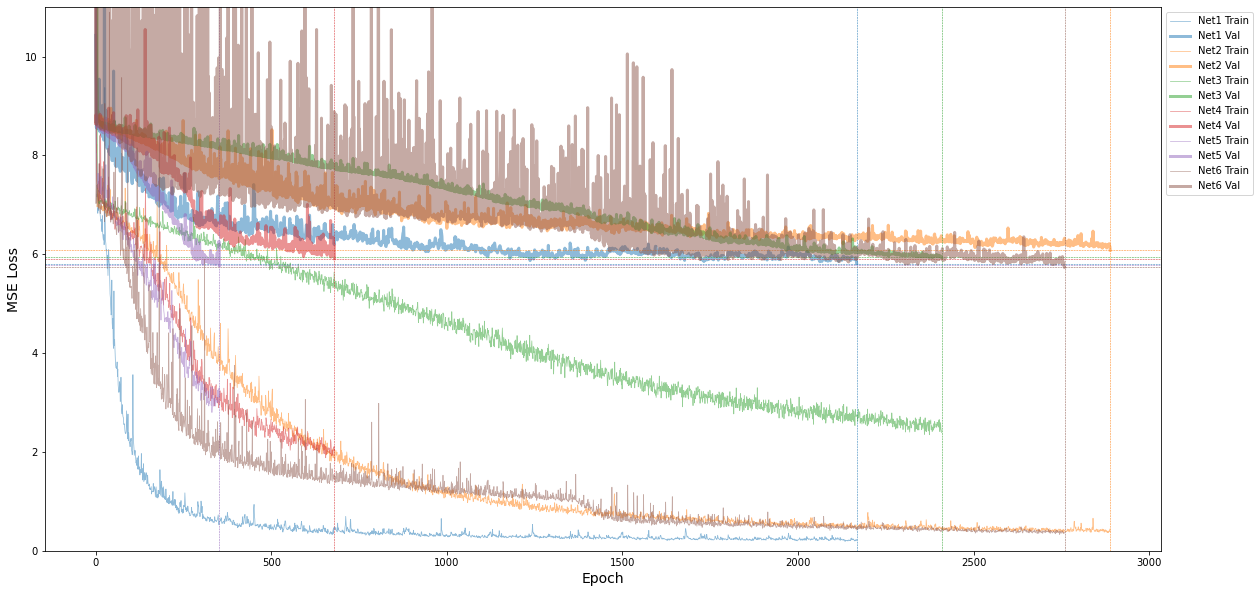

In [21]:
nets = [
    (net_regr1,'Net1'),
    (net_regr2,'Net2'),
    (net_regr3,'Net3'),
    (net_regr4,'Net4'),
    (net_regr5,'Net5'),
    (net_regr6,'Net6'),
]

sk_loss_plot(nets)

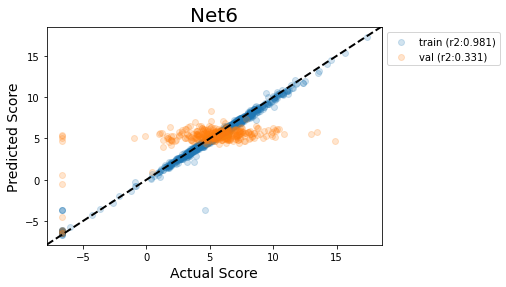

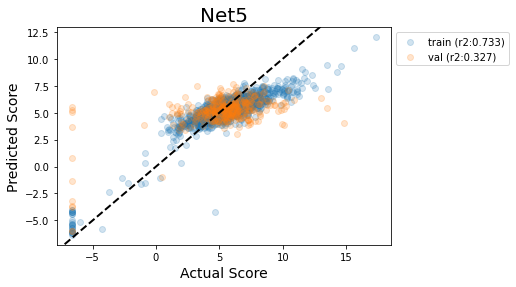

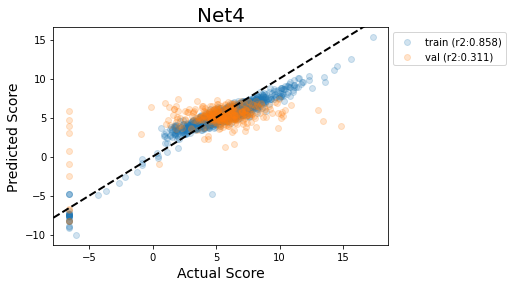

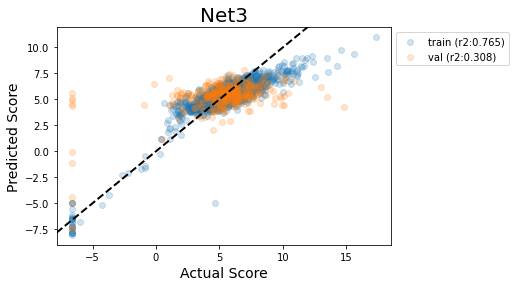

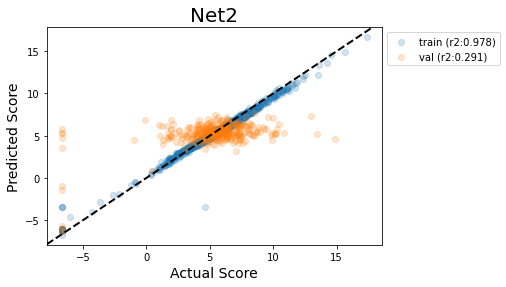

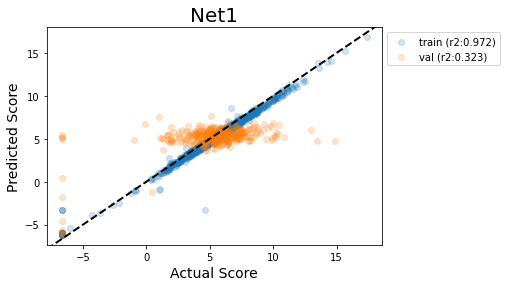

In [22]:
view_preds(nets[::-1])

# Next ideas
* Retry with low expressed genes cut out
* Retry with data aug 

# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one